In [1]:
import pandas as pd
import numpy as np
from numpy import array, median, sqrt
from hw import Jamshidian as jamsh
from hw import Henrard as henr
from hw import hw_helper
from hw import calibration as hw_calib
from hw.const import *
from fox_toolbox.utils import xml_parser, rates
from random import choice
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (15, 8)})
sns.set_style("whitegrid")

np.set_printoptions(precision=10)

%load_ext autoreload
%autoreload 2

### Read IRSM FORM

In [2]:
irsmform, irsmout = [xml_parser.get_files(regex) for regex in ['irsmform_cr', 'result']]
debug_df = pd.DataFrame()

In [3]:
processes = xml_parser.parse_processes(irsmform)

proc = processes[0]
dsc_curve, (estim_curve, *sprds) = proc.main_curve, *proc.sprd_curves
cal_basket = proc.cal_basket
mr = proc.factors.meanR

cmsp, cmtp, *other_procs = processes

In [4]:
file3m = xml_parser.get_files('libor3m')
_, (libor3m, *a) = xml_parser.get_rate_curves(file3m)

In [5]:
dfs = []
for proc in processes:
    d = []
    dsc_curve, (estim_curve, *sprds) = proc.main_curve, *proc.sprd_curves
    for swo in proc.cal_basket:
        d.append(
            {
                'expiry': swo.expiry,
                'swap_rate': swo.get_swap_rate(dsc_curve, estim_curve),
                'macs_strike': swo.strike,
                'libor_swaprate': swo.get_swap_rate(dsc_curve, libor3m)
                
            }
        )
    df = pd.DataFrame(d)
    df['Label'] = estim_curve.label
    dfs.append(df)


In [7]:
calib_strikes = pd.concat(dfs)
calib_strikes['recon%'] = 100*(calib_strikes['macs_strike'] - calib_strikes['swap_rate']) / calib_strikes['swap_rate']
calib_strikes

,expiry,libor_swaprate,macs_strike,swap_rate,Label,recon%
0,0.482192,0.019636,0.015149,0.016211,USD KGI 3M,-6.552220
1,0.986301,0.019825,0.016129,0.016121,USD KGI 3M,0.050140
2,1.482192,0.020016,0.016182,0.016167,USD KGI 3M,0.090066
3,1.991781,0.020494,0.016370,0.016341,USD KGI 3M,0.179696
4,2.482192,0.021232,0.016499,0.016486,USD KGI 3M,0.077946
5,2.989041,0.022259,0.016711,0.016684,USD KGI 3M,0.157658
6,3.479452,0.022777,0.016884,0.016846,USD KGI 3M,0.224846
7,3.989041,0.023100,0.017092,0.017053,USD KGI 3M,0.232558
8,4.484932,0.023774,0.017341,0.017283,USD KGI 3M,0.332630
0,0.482192,0.019424,0.014627,0.014590,USD TREASURY,0.252850


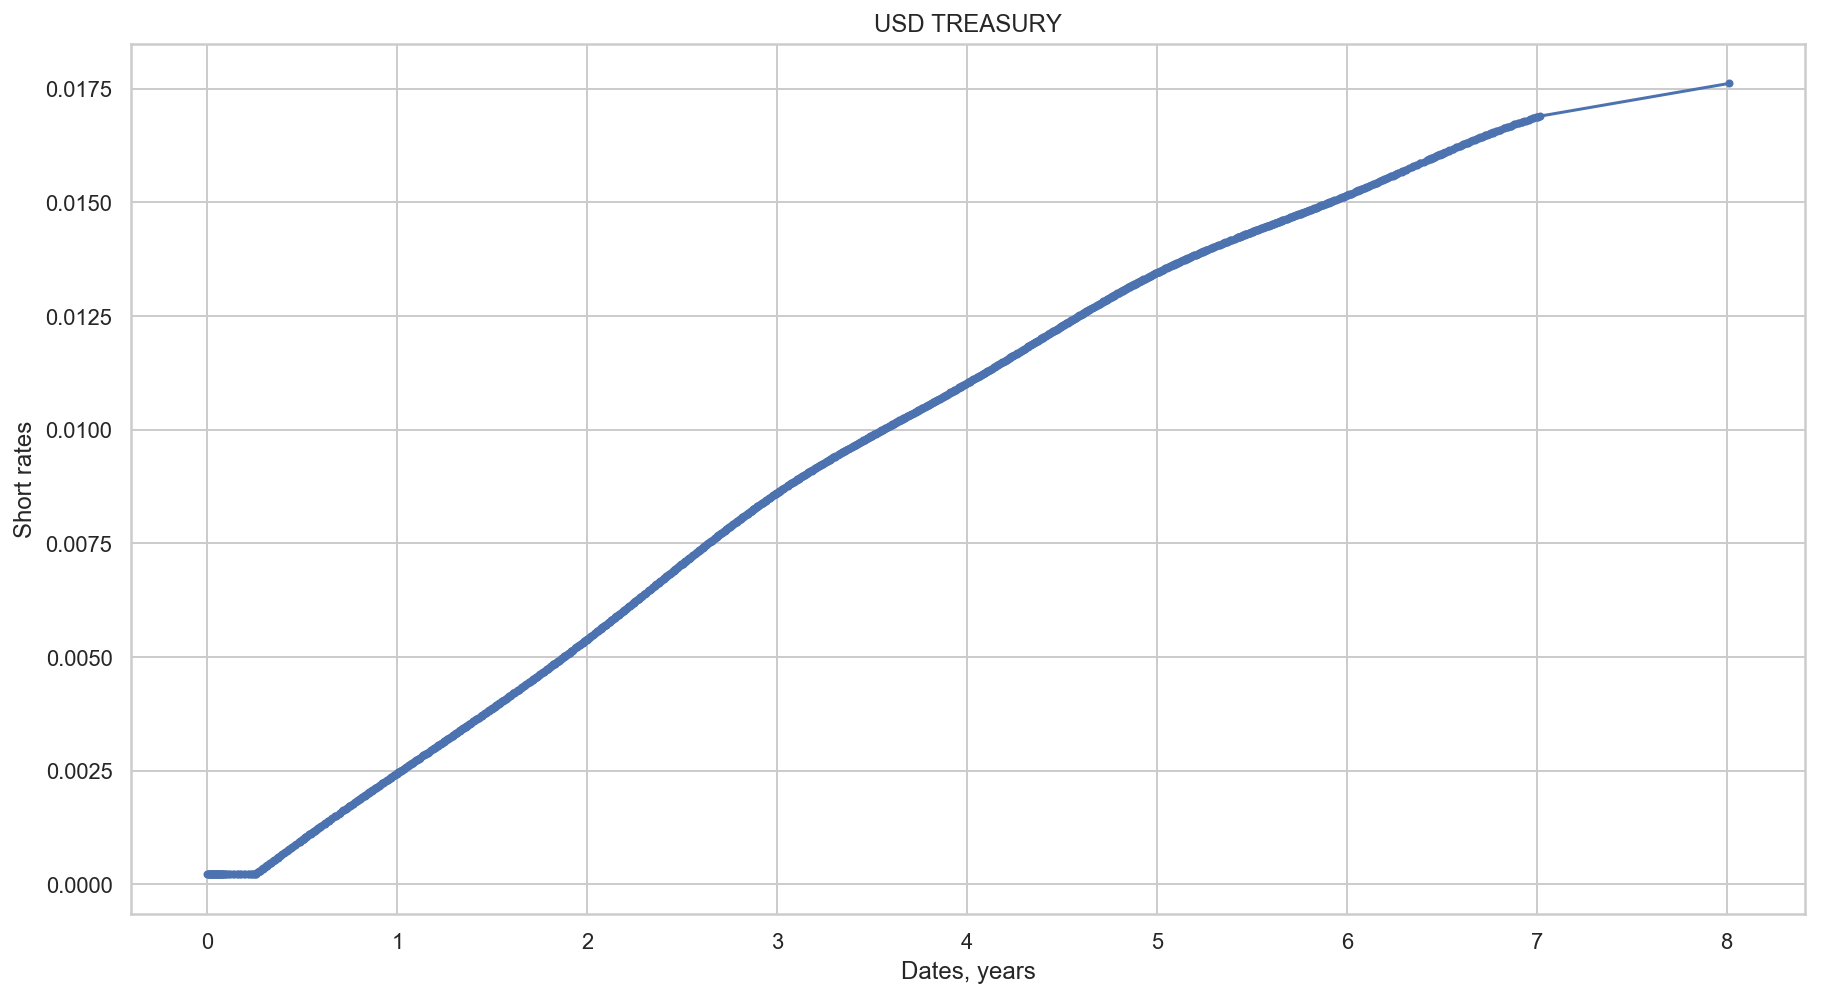

In [227]:
estim_curve.plot

Label
USD KGI 3M      AxesSubplot(0.125,0.125;0.775x0.755)
USD TREASURY    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

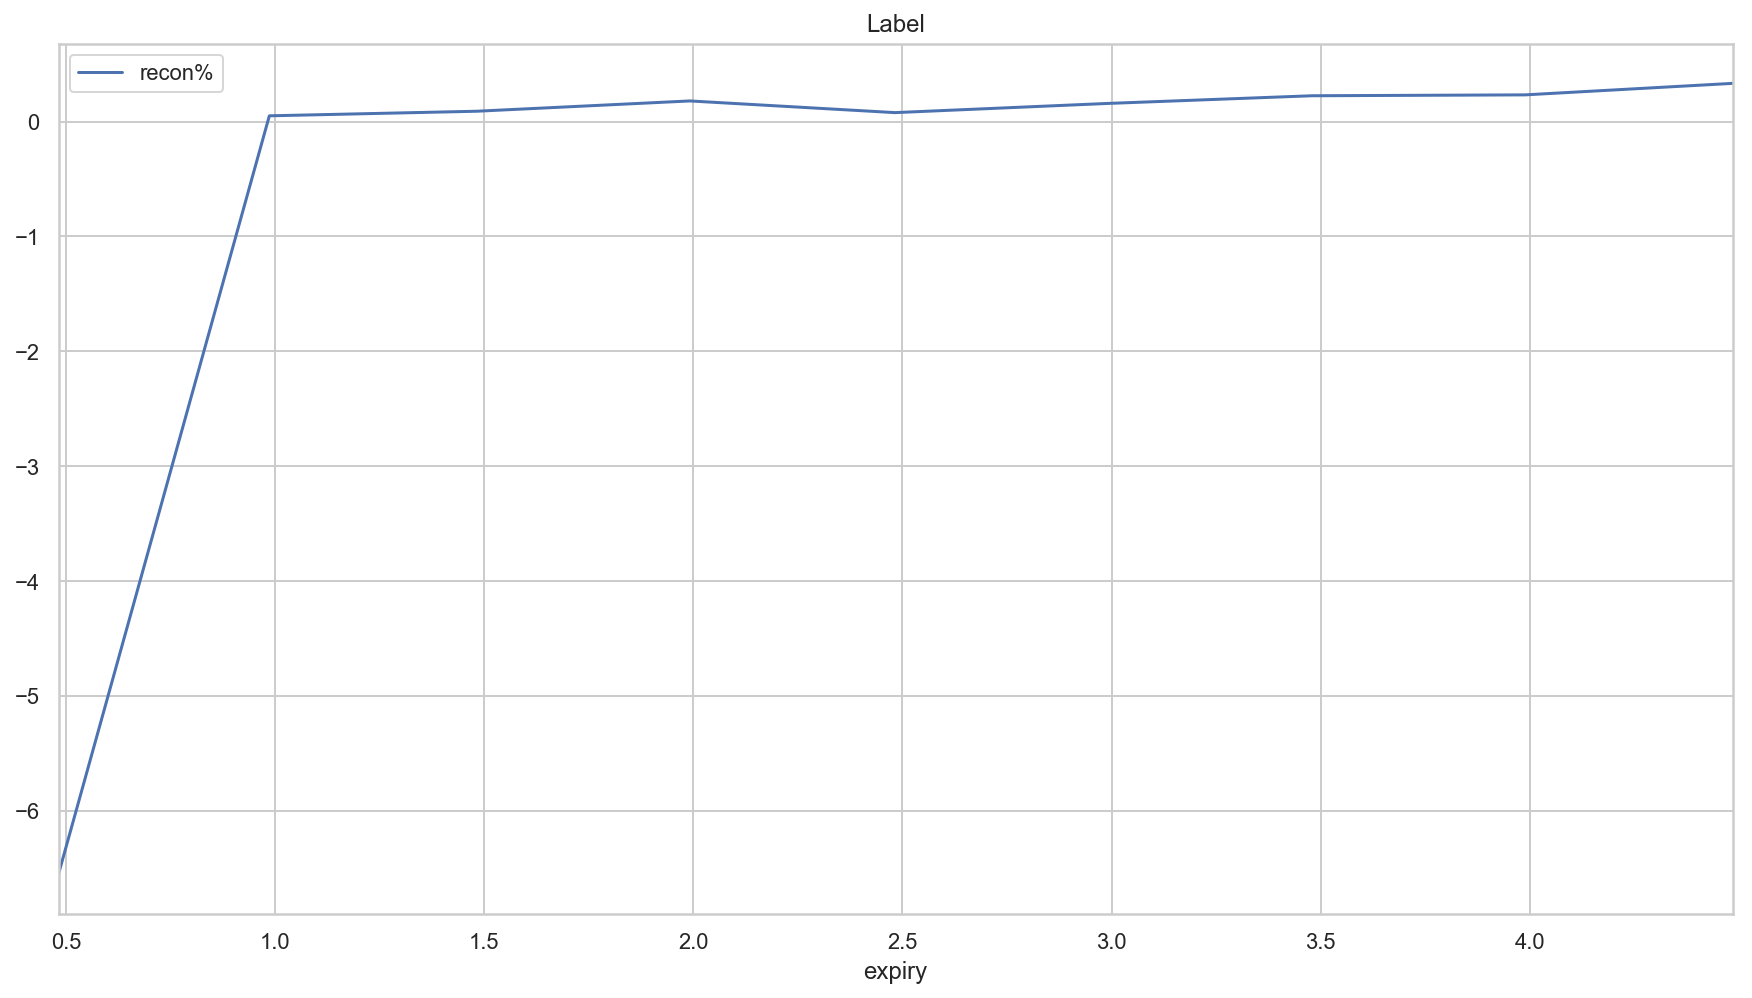

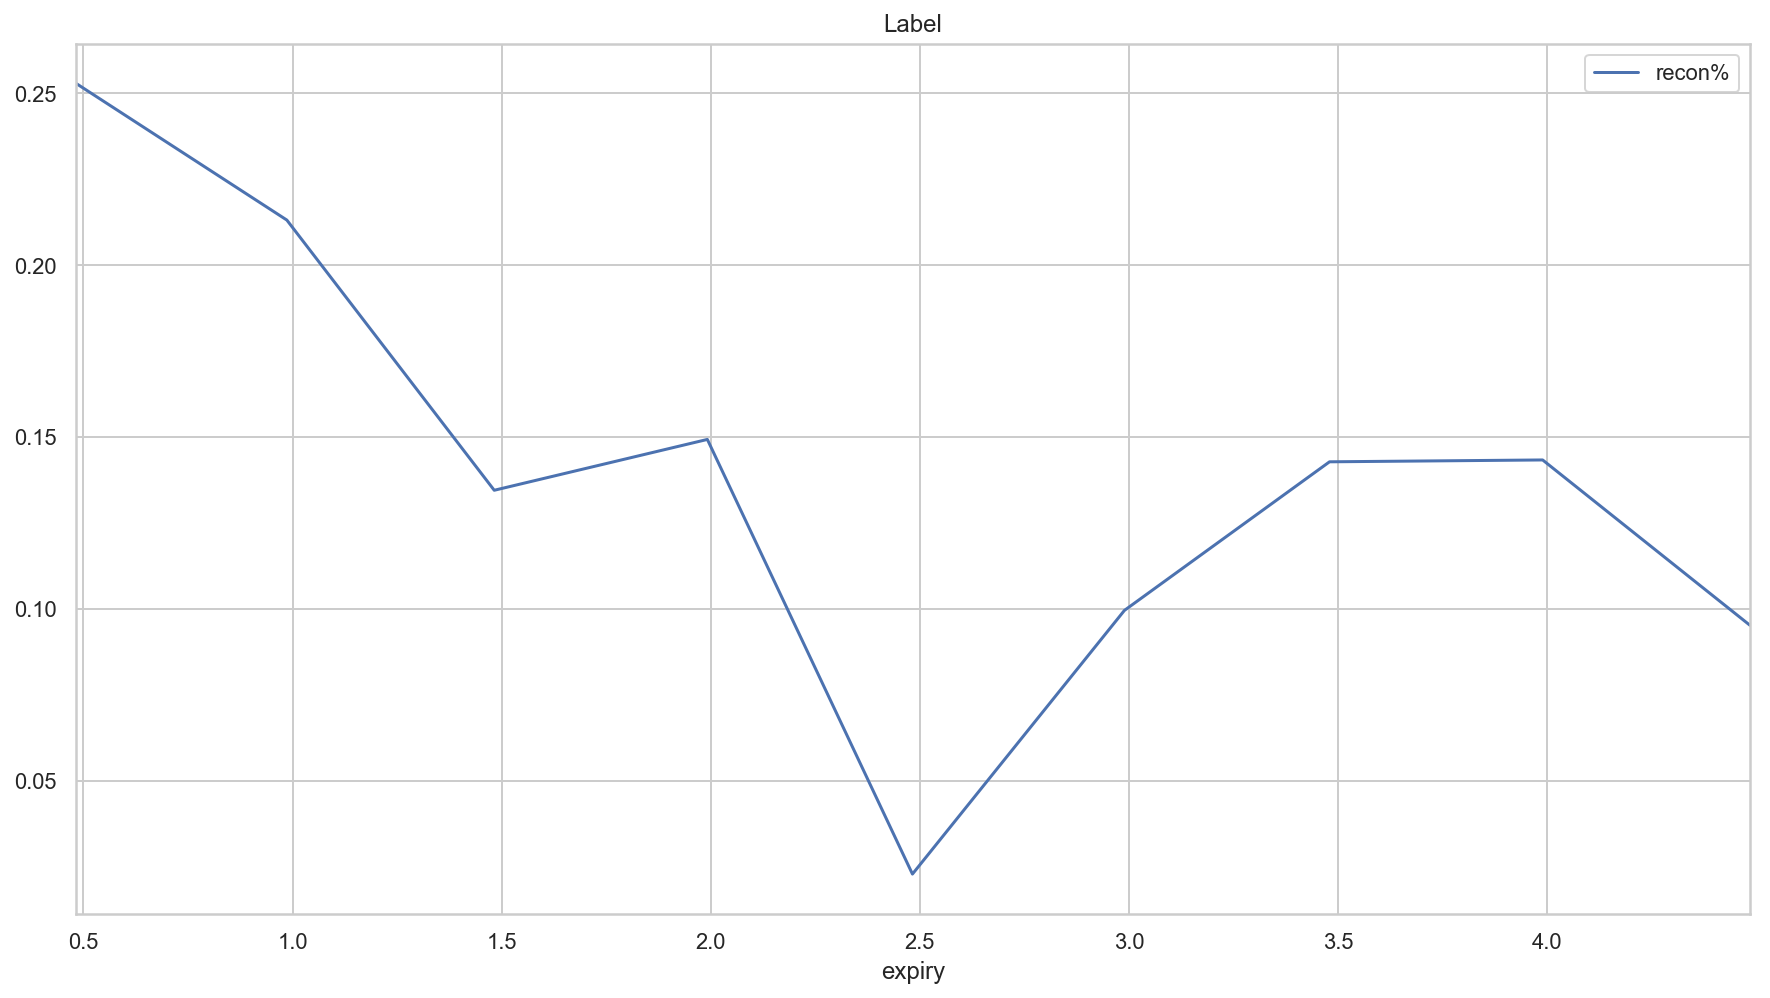

In [213]:
calib_strikes.groupby('Label').plot(x='expiry', y = 'recon%', title='Label')

### READ IRSM OUT

In [6]:
ref_swos = list(xml_parser.get_calib_basket(irsmout))
ref_mr = mr

In [7]:
ref_sigmas = xml_parser.get_hw_params(irsmout).hw_volatility

## Hernard pricer with its ref sigma

In [8]:
calib_premiumsH = []


for swo in cal_basket:

    henr_price, debug = henr.hw_swo(swo, ref_mr, ref_sigmas, dsc_curve, estim_curve)
    debug_df = pd.concat([debug_df, pd.DataFrame(data=debug)], sort=False)
    calib_premiumsH.append(henr_price)

calib_premiumsH

[0.0017855237853967032,
 0.0022953529814707108,
 0.002448987695905236,
 0.002404157885418312,
 0.002034635028439813,
 0.0015233239456680647,
 0.0008166148217094715]

## HW Calibration

In [10]:
sigma_hw_henr, debug_H = hw_calib.calibrate_sigma_hw(cal_basket, ref_mr, dsc_curve, estim_curve, IsJamsh=False)
sigma_hw_henr

Starting calibration on 7 swaptions with vol type: SLN
 at T=0.2493150684932 vol=0.005288872277806995
 at T=0.5013698630137 vol=0.0059095004843945425
 at T=0.7534246575342 vol=0.006360394758650601
 at T=1.0027397260274 vol=0.007246466555520291
 at T=1.2493150684932 vol=0.006454143106672785
 at T=1.5013698630137 vol=0.0071343222727166524
 at T=1.7534246575342 vol=0.007298925266742018


Curve(array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75, 31.75]), array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]), 'PieceWise', 'HW model sigma Henrard')

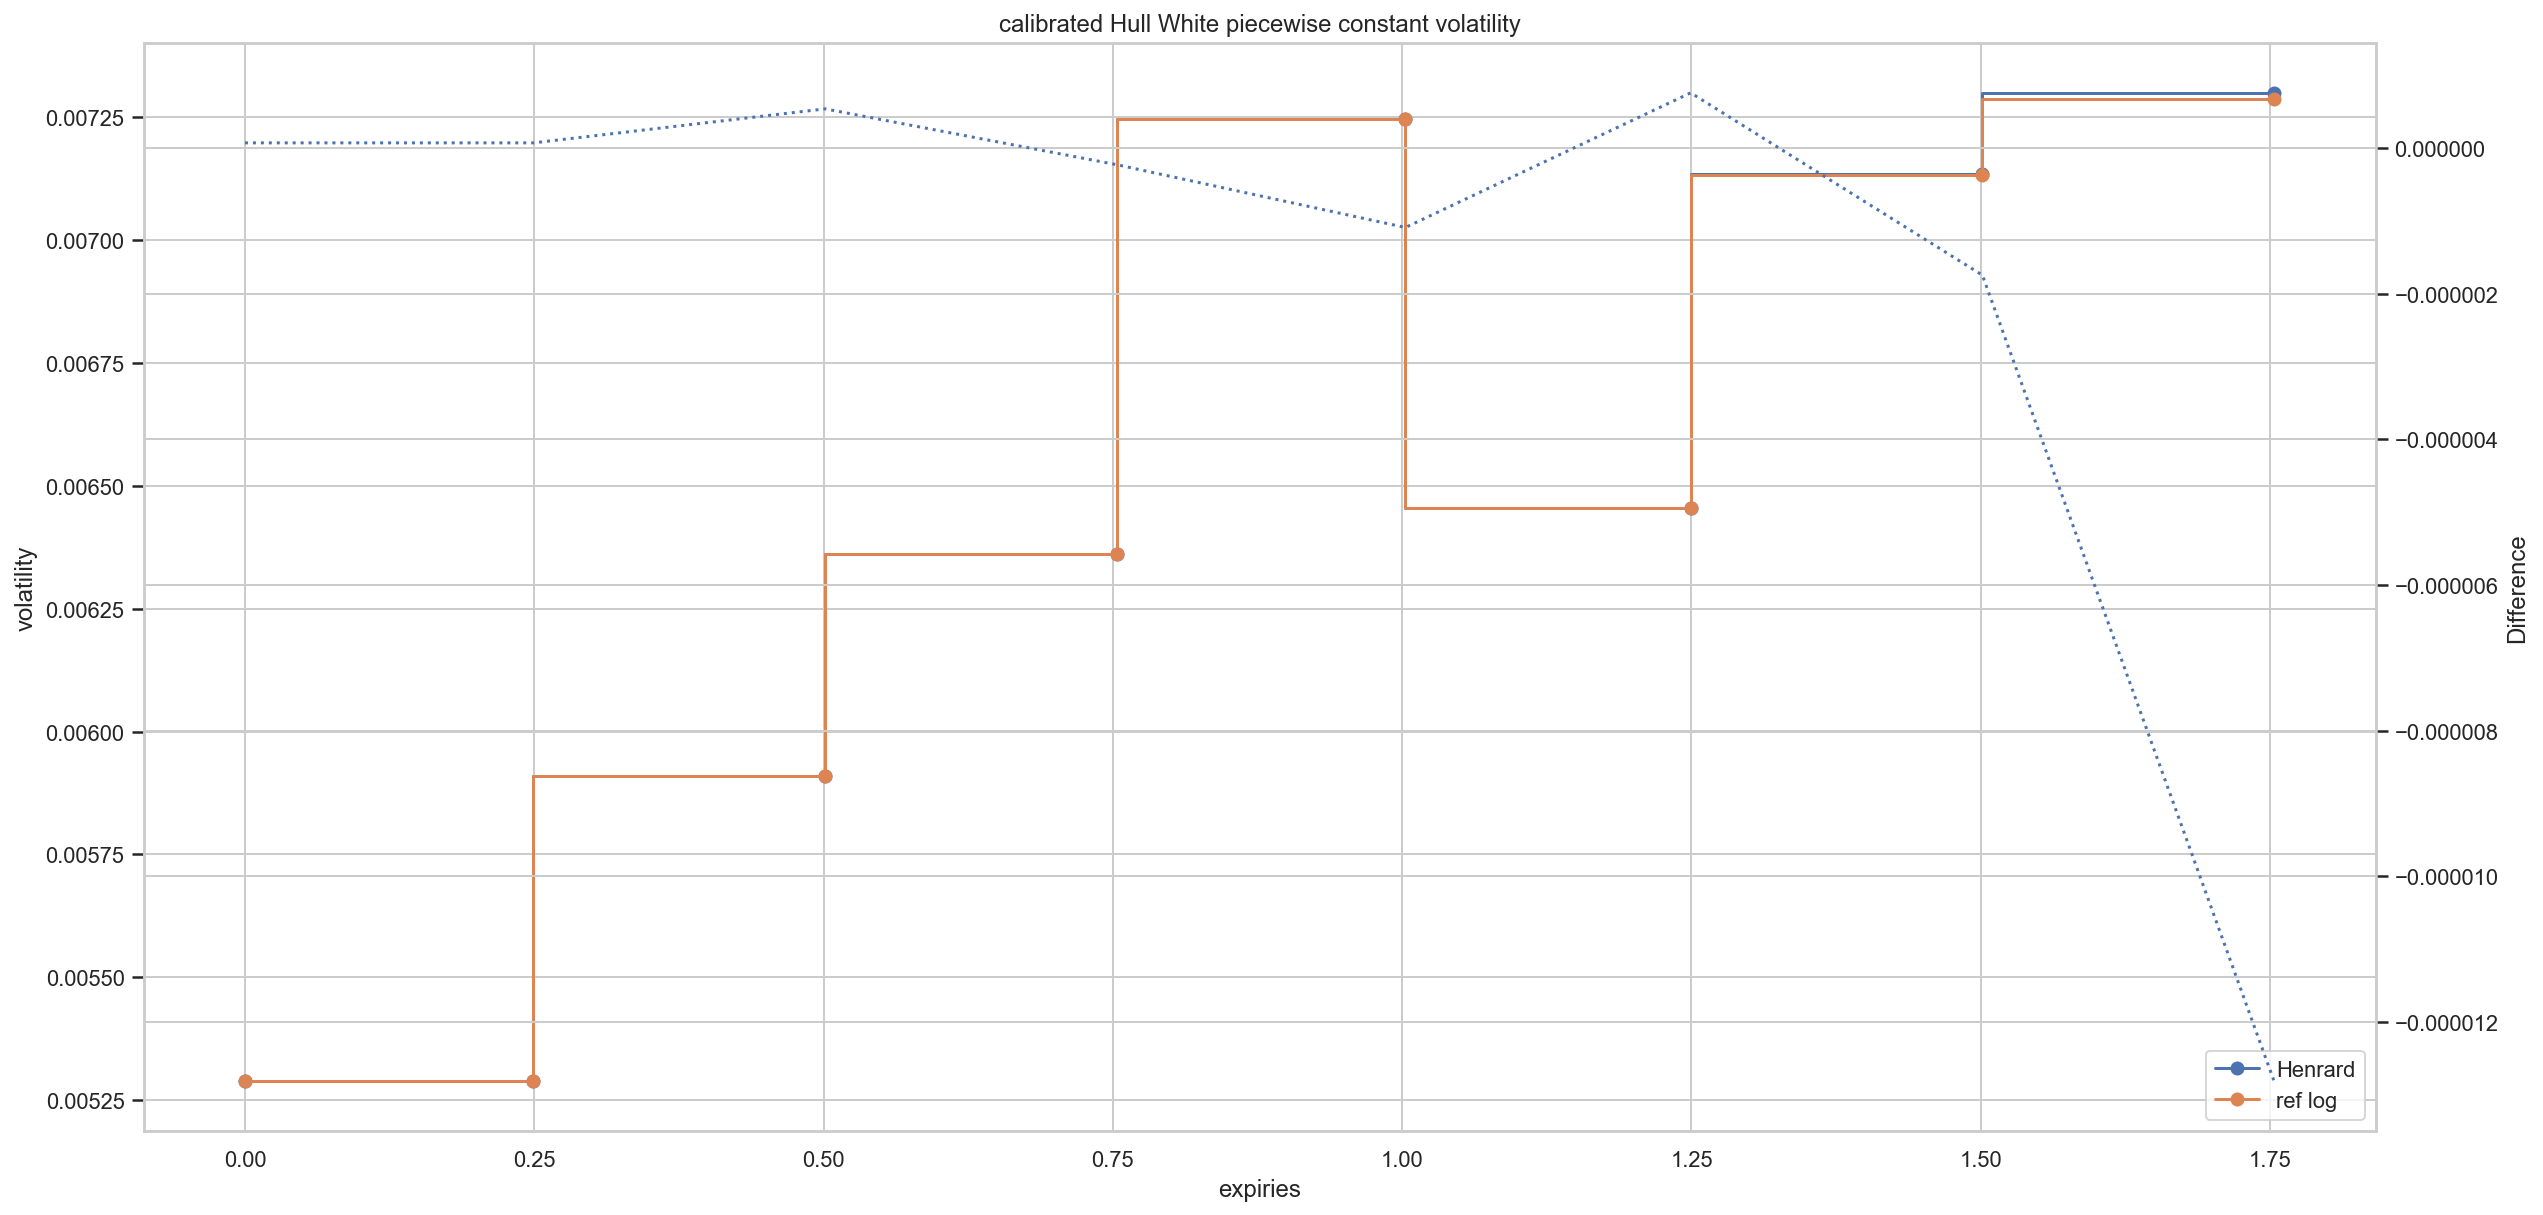

In [33]:
plt.figure(figsize=(20,10))

plt.step(sigma_hw_henr.buckets[:-1],   sigma_hw_henr.values[:-1],   label = 'Henrard', marker='o', where='pre')
plt.step(ref_sigmas.buckets[:-1], ref_sigmas.values[:-1], label = 'ref log', marker='o', where='pre')

plt.legend(loc='lower right')
plt.title('calibrated Hull White piecewise constant volatility')
plt.xlabel('expiries')
plt.ylabel('volatility')

ax = plt.twinx()  # instantiate a second axes that shares the same x-axis
ax.plot(sigma_hw_henr.buckets[:-1], ref_sigmas.values[:-1] - sigma_hw_henr.values[:-1], ls=':')
ax.set_ylabel('Difference');

In [34]:
pricesH = []
for swo in cal_basket:
    henr_price, debug = henr.hw_swo(swo, ref_mr, sigma_hw_henr, dsc_curve, estim_curve)
    pricesH.append(henr_price)

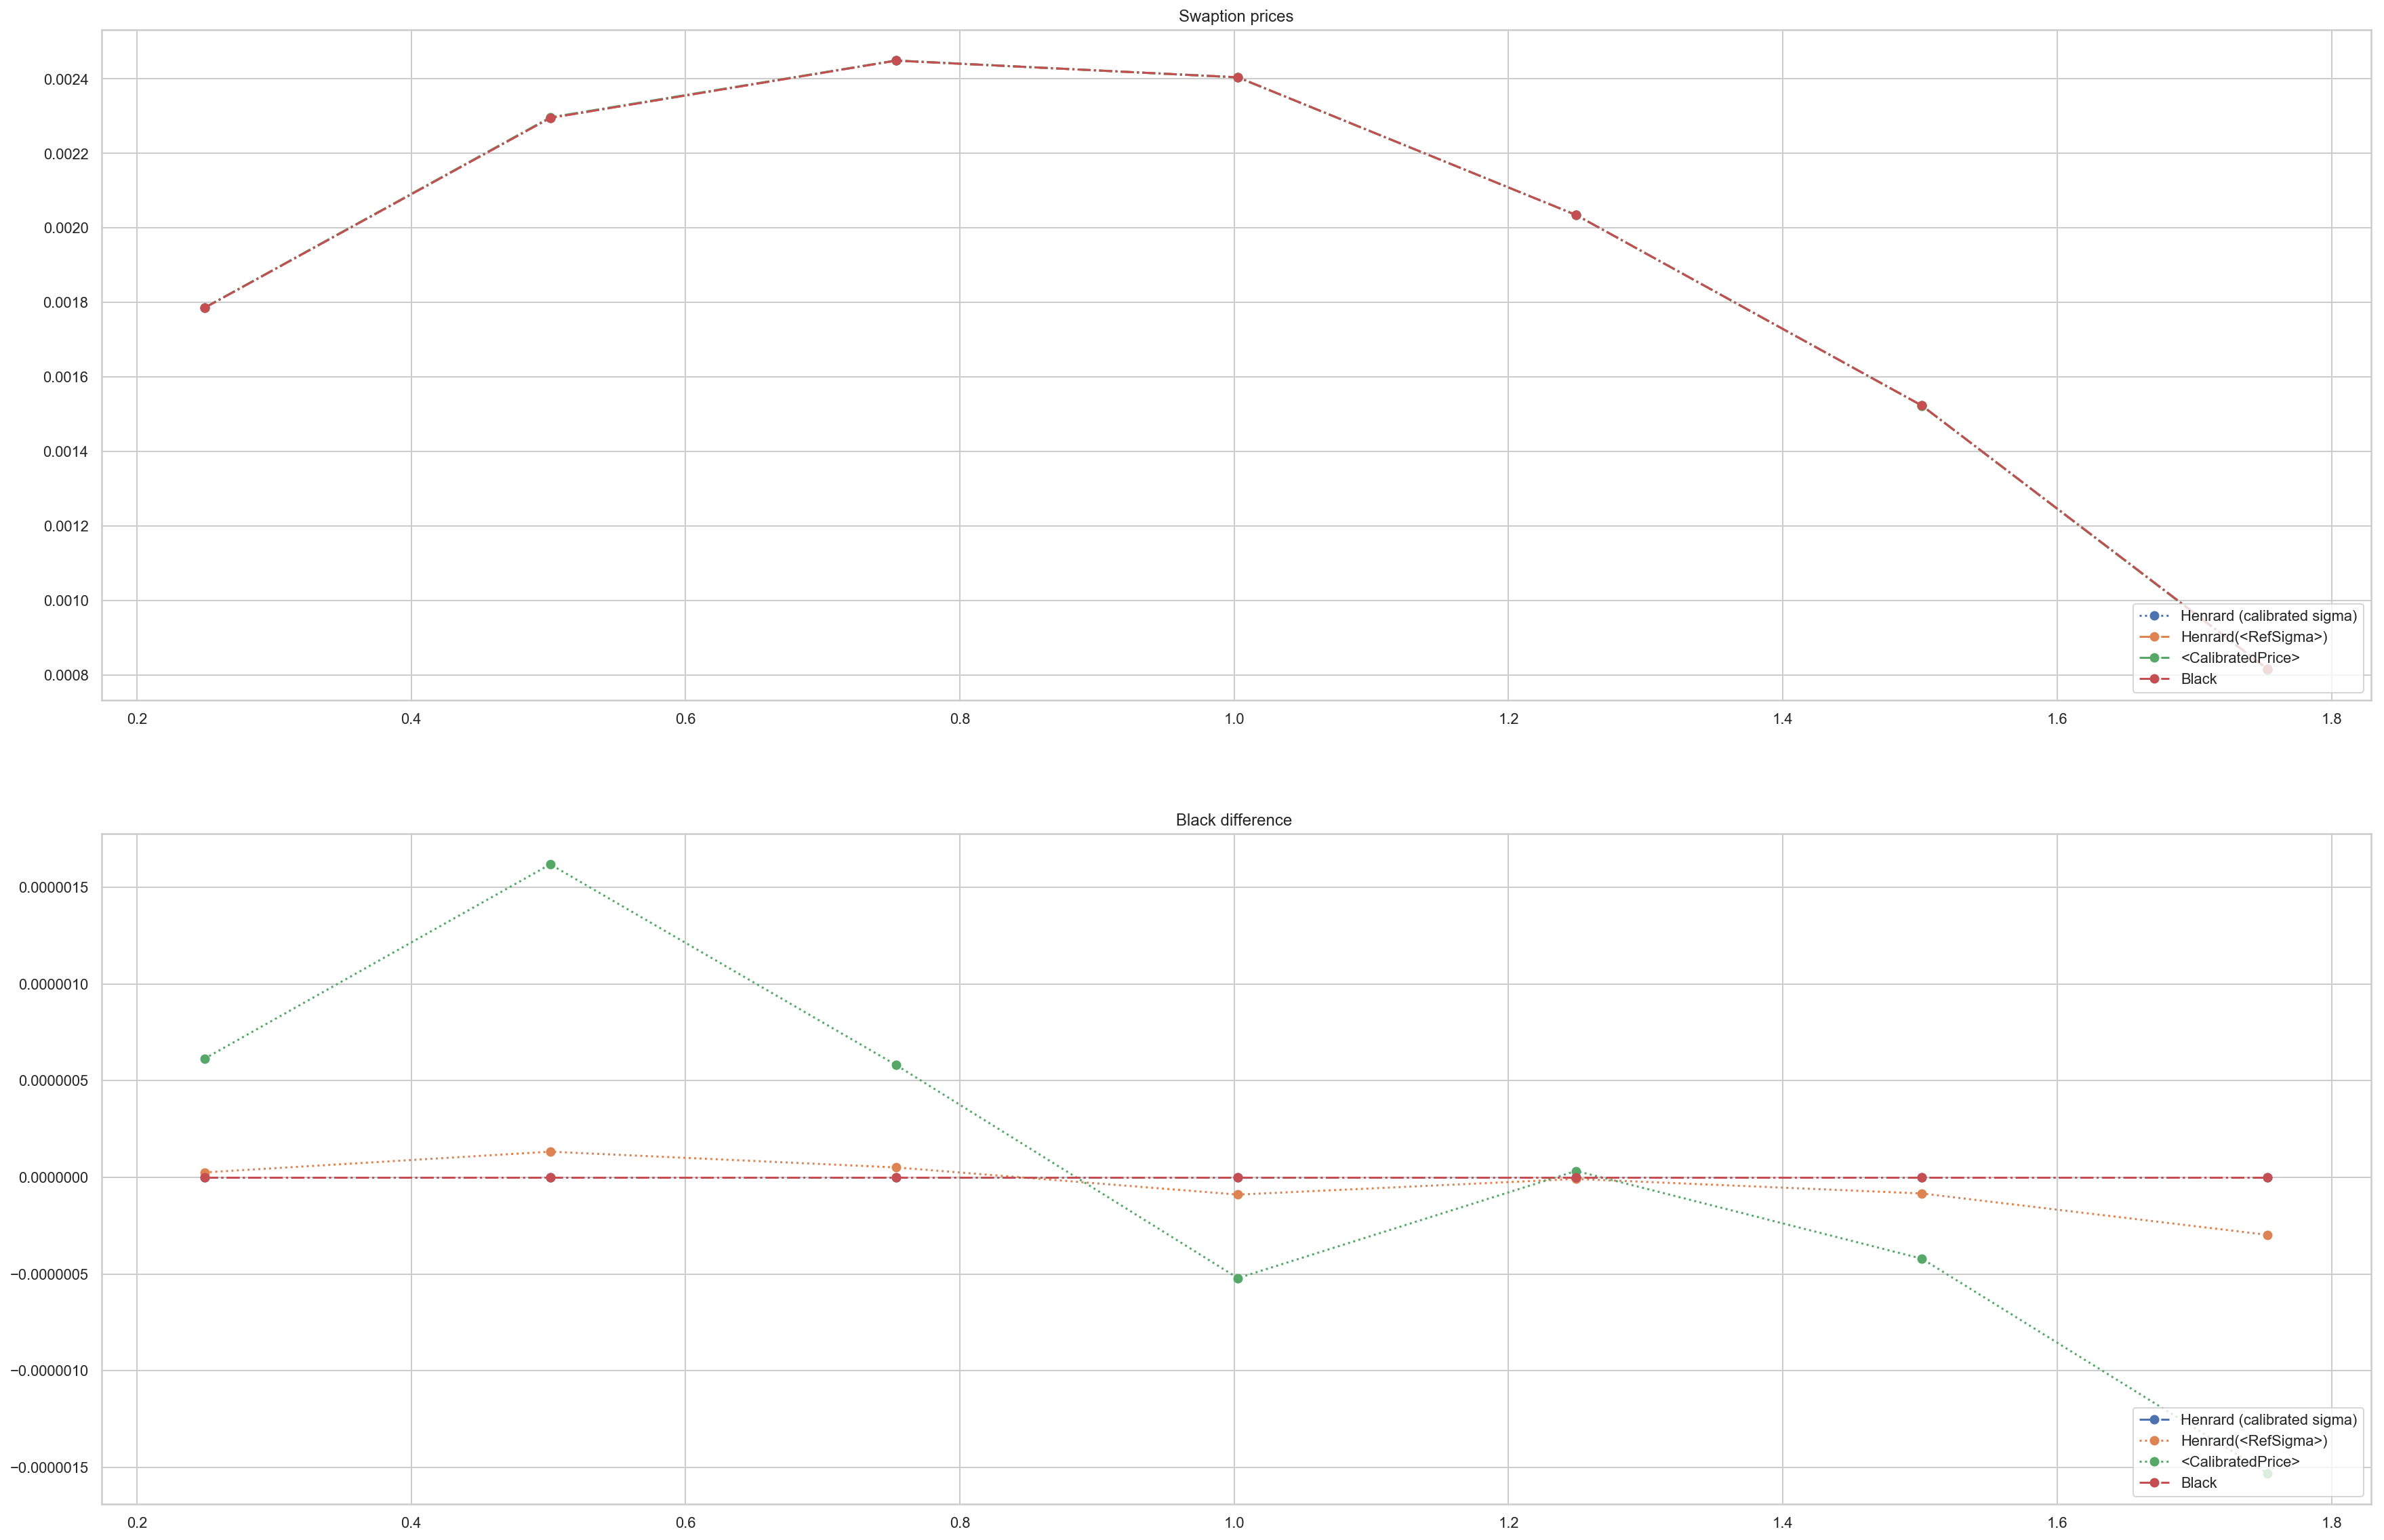

In [61]:
ref_calib_prices = [ref_swo.cal_premium for ref_swo in ref_swos]
black_prices = pd.DataFrame(data=debug_H).target_price

prices_dict = {
               
               'Henrard (calibrated sigma)':array(pricesH),
               'Henrard(<RefSigma>)': array(calib_premiumsH),
               
               '<CalibratedPrice>': array(ref_calib_prices),        
               'Black': array(black_prices)
              }

plt.subplot(2,1,1)
for lbl, prices in prices_dict.items():
    plt.plot([swo.expiry for swo in cal_basket], prices,  label = lbl, linestyle=choice([':', '--', '-.']), marker = 'o');
    
plt.title('Swaption prices');
plt.legend(loc='lower right');

plt.subplot(2,1,2)
for lbl, prices in prices_dict.items():
    plt.plot([swo.expiry for swo in cal_basket], prices - black_prices,  label = lbl, linestyle=choice([':', '--', '-.']), marker = 'o');

plt.title('Black difference ');
plt.legend(loc='lower right');

In [17]:
class X:
    def __init__(self, x):
        self.x = []
        
    def mt(self):
        return self.x

In [18]:
x = X(5.)

In [22]:
x.mt().append(3.)

In [23]:
x.mt()

[34.0, 3.0]

In [24]:
x['mt']

TypeError: 'X' object is not subscriptable